# 8.0 Final Run Template

## Summary
Explores a subset of the dataset through a replication of Leonard Evans' 2001 paper on female vs. male fatality risk. 

## Changes
- 1/20/2020 v1.0 Mitchell Abrams
- 3/26/2020 v2.0 Mitchell Abrams: update to new loaders, simplify report

In [ ]:
# These are the parameters for runs with Papermill

image_outputs = 'default'

merged = None

driver_only = False

vehicle_type = 'PASSENGER_CAR'

base_filter = f"{vehicle_type} and (SEX_C != 'Unknown') and (SEX_S != 'Unknown') and "\
                "(AGE_C < 99) and (AGE_S < 99)"

subsets = [
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
                     "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15] + [x for x in range(22, 101, 5)]
                },
     'control': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted drivers'
    }, #Unbelted drivers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted right front passengers'
    }, #Unbelted front right passengers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Used' and RESTRAINTS_S == 'Used'",
     'subject': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15] + [x for x in range(22, 101, 5)]
                },
     'control': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Belted drivers'
    }, #Belted drivers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Used' and RESTRAINTS_S == 'Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Belted right front passengers'
    }, #Belted front right passengers
    {'data': "SEAT_POS_C == 'Second Seat – Left Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted left rear passengers'
    }, #Unbelted rear left passengers
    {'data': "SEAT_POS_C == 'Second Seat – Right Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted right rear passengers'
    }, #Unbelted rear right passengers
]

In [1]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
fig_out = Path(module_path) / "reports" / "figures" / image_outputs
fig_out.mkdir(parents=True, exist_ok=True)

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['ircobi'])

from matplotlib.ticker import MultipleLocator

%matplotlib inline

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from src.data.data_loader_pooch import *
from src.data.fars_utils import createPerID, getWeightedAvg, standard_error

from tqdm.notebook import tqdm

pd.set_option('precision', 3)
pd.set_option('display.max_columns', 999)


## Load pickles

In [ ]:
data = pd.read_pickle(Path(merged))

## Full Replication

In [33]:
filtered = data.query(base_filter)

results = []
titles = []
counts = []
all_res = []
for test in tqdm(subsets):
    subset = filtered.query(test['data']).reset_index().drop(columns=['index'])
    subject = test['subject']
    control = test['control']

    control_bins = pd.cut(x=subset[control['age']], bins=control['bin'])
    subject_bins = pd.cut(x=subset[subject['age']], bins=subject['bin'])

    subset['AGE_C_Bin'] = control_bins
    subset['AGE_S_Bin'] = subject_bins

    grouped = subset.groupby(['AGE_C_Bin', 'AGE_S_Bin', control['sex']])

    soln = []

    for name, group in grouped:
        #print(name)
        a = group.loc[(group[subject['sex']] == 'Female') 
                      & (group[subject['dead']])]
        b = group.loc[(group[subject['sex']] == 'Female') 
                      & (group[control['dead']])]
        c = group.loc[(group[subject['sex']] == 'Male') 
                      & (group[subject['dead']])]
        d = group.loc[(group[subject['sex']] == 'Male') 
                      & (group[control['dead']])]

        A = a[subject['id']].nunique()
        B = b[control['id']].nunique()
        C = c[subject['id']].nunique()
        D = d[control['id']].nunique()
        if (A > 0) and (B>0) and (C > 0) and (D > 0):
            r1 = A/B
            r2 = C/D
            R = r1/r2
            serr = standard_error(R, A, B, C, D)
            soln.append([name[0], name[1], name[2], A, B, C, D, r1, r2, R, serr])

    #print(soln)
    result = pd.DataFrame(soln, columns = ['Control Age', 'Subject Age', 'Control Sex', 'A', 'B', 'C', 'D', 'r1', 'r2', 'R', 'DeltaR'])
    weighted_result = result.groupby(['Subject Age']).apply(getWeightedAvg).reset_index()

    weighted_result['Age'] = weighted_result['Subject Age'].apply(lambda x: x.mid + .5)
    this_count = result['A'].sum() + result['C'].sum()
    results.append(weighted_result.copy())
    all_res.append(result.copy())
    titles.append(test['title'])
    counts.append(this_count)
    
vehicle_results = {'results': results,
                   'titles': titles,
                   'counts': counts,
                   'all_res': all_res}

In [34]:
def plot_doublepair(vehicle_results):
    fig, axes = plt.subplots(3,2, figsize=(10,9), sharex=True, sharey=True)
    results = vehicle_results['results']
    titles = vehicle_results['titles']
    counts = vehicle_results['counts']
    a=[]
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            a.append(ax)

    for i, ax in enumerate(a):
        ax.axhline(1, color='black', lw=1, ls='--')
        #print(results)
        if not results[i].empty:
            results[i].plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
                      ylim = (.5, 2), title=titles[i],
                       ax = ax, legend=False)
            ax.text(55, 1.85, f"{counts[i]: ,} Fatalities", fontsize=12)

            ax.xaxis.set_major_locator(MultipleLocator(10))
            ax.xaxis.set_minor_locator(MultipleLocator(5))
            ax.tick_params(which='major', length=7)
            ax.tick_params(which='minor', length=4)
            #axis.yaxis.set_major_locator(MultipleLocator(10))
            ax.yaxis.set_minor_locator(MultipleLocator(.1))

    plt.show()
    return fig

In [34]:
def plot_driver_only(vehicle_results):
    fig, axes = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)
    results = vehicle_results['results']
    titles = vehicle_results['titles']
    counts = vehicle_results['counts']
    a=[]
    for i, ax in enumerate(axes):
        a.append(ax)

    for i, ax in enumerate(a):
        ax.axhline(1, color='black', lw=1, ls='--')
        results[i].plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
                      ylim = (.5, 2), title=titles[i],
                       ax = ax, legend=False)
        ax.text(55, 1.85, f"{counts[i]: ,} Fatalities", fontsize=12)

        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=4)
        #axis.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(.1))

    plt.show()
    return fig

In [52]:
def combine_results(results):
    combined = pd.concat(results,sort=True).reset_index()
    combined['Age'] = pd.cut(x=combined['Age'], bins=[x for x in range(0, 101, 5)]).apply(lambda x: x.mid)
    combined = combined.groupby('Age')
    overall_result = combined.apply(getWeightedAvg).reset_index()
    return overall_result

In [40]:
def plot_single(result, counts, title):
    fig, ax = plt.subplots()
    ax.axhline(1, color='black', lw=1, ls='--')
    result.plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
                ylim = (.5, 2), title=title,
                ax = ax, legend=False)
    ax.text(55, 1.4, f"{sum(counts): ,} Fatalities", fontsize=12)
    plt.show()
    return fig

## Results: Passenger Cars

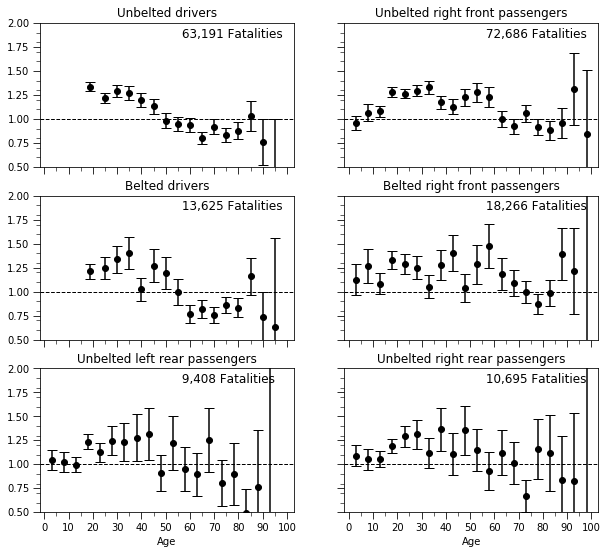

In [35]:
if not driver_only:
    fig = plot_doublepair(vehicle_results)
    #fig.savefig(fig_out / "passenger_car_subsets.png")
else:
    fig = plot_driver_only(vehicle_results)
    fig.savefig(fig_out / "passenger_car_subsets.png")

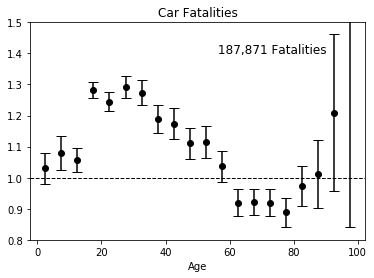

In [47]:
car_result = combine_results(vehicle_results['results'])
car_counts = vehicle_results['counts']
fig = plot_single(car_result, car_counts, "Car Fatalities")
fig.savefig(fig_out / "passenger_cars.png", dpi=360)

## Tables
Tables produced for review, also output as .xlsx and .csv files for easy transfer to papers.

In [ ]:
csv_out = Path(module_path) / "reports" / "tables" / image_outputs / "csv"
xlsx_out = Path(module_path) / "reports" / "tables" / image_outputs / "xlsx"
csv_out.mkdir(parents=True, exist_ok=True)
xlsx_out.mkdir(parents=True, exist_ok=True)

In [ ]:
veh_type = vehicle_type
cur_veh = vehicle_results
veh_csv = csv_out / veh_type
veh_xlsx = xlsx_out / veh_type

veh_csv.mkdir(parents=True, exist_ok=True)
car_result.to_csv(veh_csv / "full_weighted.csv")

for title, res, all_res in zip(cur_veh['titles'], 
                               cur_veh['results'], 
                               cur_veh['all_res']):
    cur_csv = veh_csv / title
    cur_xlsx = veh_xlsx / title
    cur_csv.mkdir(parents=True, exist_ok=True)
    cur_xlsx.mkdir(parents=True, exist_ok=True)

    #Write out table of weighted results
    res.to_csv(cur_csv / 'weighted_results.csv', float_format='%.3f')
    #res.to_excel(cur_xlsx / 'weighted_results.csv')

    #Write out table of all results
    all_res.to_csv(cur_csv / 'full_results.csv', float_format='%.3f')

    #Loop through each subject interval in all_res, write out this table
    for subj_age in all_res['Subject Age'].unique():
        cur_chunk = all_res.loc[all_res['Subject Age'] == 
                                subj_age].sort_values('Control Sex', ascending=False)
        cur_chunk.to_csv(cur_csv / f"subjects_{subj_age}.csv", float_format='%.3f')

In [ ]:
del(data, filtered)

In [ ]:
%reset -f